# Hybrid CNN-LSTM Neural Network in TensorFlow/Keras

Import Required Libraries

In [1]:
# TensorFlow and Keras are the core libraries used for building the neural network.
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, GlobalAveragePooling1D, Dense,
    Dropout, LSTM, concatenate
)

# NumPy is used for creating sample input data
import numpy as np

# Optional: suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Show versions for reproducibility
print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.19.0


# Define Input Shapes and Parameters

In [2]:
# Define the shape of the input sequences.
# Let's say we are working with sequences of 100 time steps and 10 features per time step.
sequence_length = 100
num_features = 10

# Input shape will be (100, 10) for both CNN and LSTM branches.
input_shape = (sequence_length, num_features)

# Set other training parameters
dropout_rate = 0.3  # Dropout rate used in various places to prevent overfitting
dense_units = 32    # Number of units in dense layers for both CNN and LSTM
lstm_units = 50     # Number of units in the LSTM layer


# Build the CNN Branch

In [3]:
# Input layer for CNN branch
cnn_input = Input(shape=input_shape, name='cnn_input')

# First layer is a 1D Convolution layer with 64 filters and a kernel size of 3
# Activation function is ReLU
cnn_conv = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn_input)

# Global Average Pooling reduces the output dimensions from 3D to 2D
cnn_pool = GlobalAveragePooling1D()(cnn_conv)

# Fully connected (Dense) layer with 32 units and ReLU activation
cnn_dense = Dense(dense_units, activation='relu')(cnn_pool)

# Dropout layer to reduce overfitting
cnn_dropout = Dropout(dropout_rate)(cnn_dense)


# Build the LSTM Branch

In [4]:
# Input layer for LSTM branch
lstm_input = Input(shape=input_shape, name='lstm_input')

# LSTM layer with 50 units
# This layer captures temporal patterns in the sequential input
lstm_layer = LSTM(lstm_units)(lstm_input)

# Fully connected layer to transform LSTM output
lstm_dense = Dense(dense_units, activation='relu')(lstm_layer)


# Concatenate Outputs from CNN and LSTM

In [5]:
# Concatenate outputs from both branches
# This combines the feature representations learned from both the CNN and LSTM
merged = concatenate([cnn_dropout, lstm_dense])

# Further dense layer to mix the concatenated features
merged_dense = Dense(64, activation='relu')(merged)

# Additional dropout to improve generalization
merged_dropout = Dropout(dropout_rate)(merged_dense)

# Final output layer with sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(merged_dropout)


# Create and Compile the Model

In [6]:
# Define the model by specifying the input and output layers
model = Model(inputs=[cnn_input, lstm_input], outputs=output)

# Compile the model with appropriate loss function and optimizer
# Use 'binary_crossentropy' for binary classification tasks
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary to see the layer details
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │      1,984 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_input          │ (None, 100, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     12,200 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,632 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,121 (86.41 KB)

 Trainable params: 22,121 (86.41 KB)

 Non-trainable params: 0 (0.00 B)

# Generate Dummy Data for Testing

In [7]:
# Let's generate some dummy training data to simulate model training
# We'll generate 1000 samples, each with 100 time steps and 10 features

num_samples = 1000

# Random float data for CNN and LSTM branches
X_cnn = np.random.rand(num_samples, sequence_length, num_features)
X_lstm = np.random.rand(num_samples, sequence_length, num_features)

# Binary target labels (0 or 1)
y = np.random.randint(0, 2, size=(num_samples, 1))

# Split into training and validation sets (80/20 split)
split = int(num_samples * 0.8)
X_cnn_train, X_cnn_val = X_cnn[:split], X_cnn[split:]
X_lstm_train, X_lstm_val = X_lstm[:split], X_lstm[split:]
y_train, y_val = y[:split], y[split:]

# Check shapes
print("Training data shape:", X_cnn_train.shape, X_lstm_train.shape, y_train.shape)
print("Validation data shape:", X_cnn_val.shape, X_lstm_val.shape, y_val.shape)


Training data shape: (800, 100, 10) (800, 100, 10) (800, 1)
Validation data shape: (200, 100, 10) (200, 100, 10) (200, 1)


# Train the Model

In [9]:
# Fit the model on the training data
# Use validation data to monitor performance
history = model.fit(
    [X_cnn_train, X_lstm_train], y_train,
    validation_data=([X_cnn_val, X_lstm_val], y_val),
    epochs=15,
    batch_size=32
)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4832 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4987 - loss: 0.6935 - val_accuracy: 0.5350 - val_loss: 0.6913
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5055 - loss: 0.6933 - val_accuracy: 0.5350 - val_loss: 0.6914
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5228 - loss: 0.6921 - val_accuracy: 0.5350 - val_loss: 0.6919
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4978 - loss: 0.6951 - val_accuracy: 0.5350 - val_loss: 0.6911
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4945 - loss: 0.6930 - val_accuracy: 0.5350 - val_loss: 0.6910
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5029 - loss: 0.6916 - val_accuracy: 0.5350 - val_loss: 0.6915
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5504 - loss: 0.6894 - val_accuracy: 0.4600 - val_l

# Visualize Training Histor

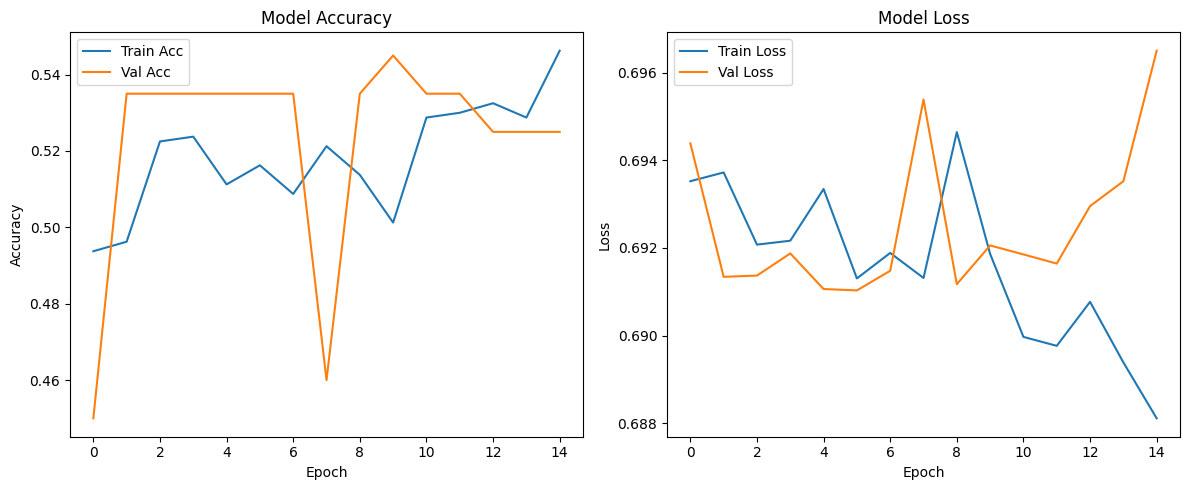

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
